In [2]:
import sys, os
if os.path.exists("/home/cb2714/wwa/wwa.py"):
     sys.path.append('/home/cb2714/wwa/')
else:
     sys.path.append('/rds/general/user/cb2714/home/wwa/')
from wwa import *

from taylorDiagram import TaylorDiagram, taylor_scores

xn, xx, yn, yx = [125,146,30,46]  # larger region for data retrieval
xn, xx, yn, yx = [125,133,30,40]  # smaller region for plotting

mapproj = cartopy.crs.PlateCarree()

rnm = "kr"

In [3]:
def seasonal_cycle(ts, sm = 1):
    
    # (possibly smoothed) climatology from 1990-2020, excluding day 366 (can lead to weird jumps in the series)
    sc = ts.rolling(time = sm, center = True).mean().sel(time = slice("1990","2020")).groupby("time.dayofyear").mean()
    
    return sc

def scale(ts): return (ts - ts.mean()) / ts.std()

# Seasonal cycle

In [25]:
framing = "princeton"
varnm = "pr"
ndays = 15

# load obs
if varnm[:2] == "pr":
    ts = xr.open_dataset("daily-ts/pr_era5_195001-202503_"+rnm+".nc")
else:
    ts = xr.open_dataset(sorted(glob.glob("daily-ts/"+varnm+"*era5land*"+rnm+".nc"))[-1])
ts = ts[list(ts.data_vars)[0]]
sc_obs = seasonal_cycle(ts, ndays)

# list models & set up figures
fl = sorted(glob.glob("daily-ts/"+framing+"/"+varnm+"*"))
# if framing == "cmip6": fl = glob.glob('daily-ts/local-hires/'+varnm+'*_kr.nc')  + fl

nc = min(4, len(fl)); nr = int(np.ceil(len(fl)/nc))
y_ttl = {"cmip6" : 0.93, "highressst" : 0.93, "princeton" : 1}[framing]

days = pd.date_range(start = "2020-01-01", end = "2021-01-01")
labelticks = [i+1 for i in range(len(days)) if (days[i].day) == 15]
labels = [days[i].strftime("%b")[0] for i in range(len(days)) if (days[i].day) == 15]

col = {"hdwi-from-hursmin" : "tab:orange", "hdwi" : "tab:orange", "tasmax" : "firebrick", "hursmin" : "tab:green", "sfcWindmax" : "powderblue", "pr" : "tab:blue"}[varnm]

if varnm[:2] == "pr": 
    d_start = ts.sel(time = "2025-02-01").time.dt.dayofyear.values
    d_width = 59
else:
    d_start = ts.sel(time = "2025-03-01").time.dt.dayofyear.values
    d_width = 31

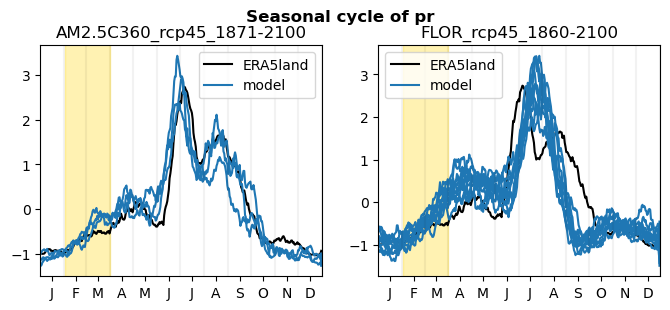

In [26]:
fig, axs = plt.subplots(ncols = nc, nrows = nr, figsize = (nc * 4, nr * 3), dpi = 100)
plt.subplots_adjust(hspace = 0.3)

for i in range(len(fl)):
    ax = fig.axes[i]
    
    mts = xr.open_dataset(fl[i])
    mts = mts[list(mts.data_vars)[0]]
    sc = seasonal_cycle(mts, sm = ndays)
    
    if framing == "princeton": sc = sc.transpose()
    
    ax.plot(scale(sc_obs), color = "k", label = "ERA5land")
#     ax.plot(mswx, color = "darkblue")
    
    ax.plot(scale(sc), color = col, label = "model")
    
    ax.set_xticks(labelticks)
    ax.set_xticklabels(labels)
    [ax.axvline(x, color = "k", alpha = 0.05) for x in range(len(days)) if (days[x].day) == 1]
    
    ylim = ax.get_ylim()
    ax.add_patch(Rectangle((d_start, ylim[0]-10), d_width, ylim[1]+20, color = "gold", alpha = 0.3))
    ax.set_ylim(ylim)
    
    gcm = "_".join(fl[i].split("_")[1:4])
    if "25km" in gcm: gcm = "AWI-CW3 25km"
    ax.set_title(gcm)
    ax.legend(["ERA5land", "model"])
    ax.margins(x = 0)
    
for i in range(len(fl), len(fig.axes)): fig.axes[i].set_axis_off()
    
plt.suptitle("Seasonal cycle of "+re.sub("-"," ",varnm), fontweight = "bold", y = y_ttl)
plt.savefig("fig/mdl-eval_seasonal-cycle_"+varnm+"-scaled_"+framing+".png")

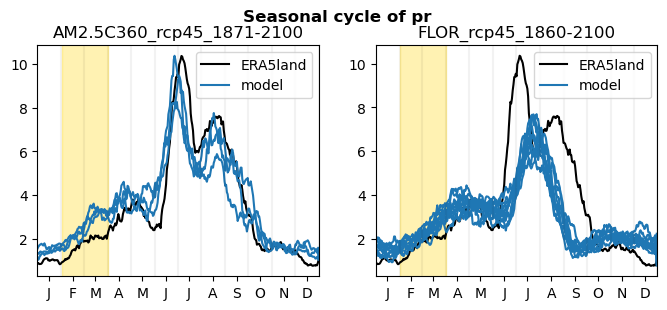

In [27]:
fig, axs = plt.subplots(ncols = nc, nrows = nr, figsize = (nc * 4, nr * 3), dpi = 100)
plt.subplots_adjust(hspace = 0.3)

for i in range(len(fl)):
    ax = fig.axes[i]
    
    mts = xr.open_dataset(fl[i])
    mts = mts[list(mts.data_vars)[0]]
    sc = seasonal_cycle(mts, sm = ndays)
    if framing == "princeton": sc = sc.transpose()
    
    ax.plot((sc_obs), color = "k", label = "ERA5land")
#     ax.plot(mswx, color = "darkblue")
    ax.plot((sc), color = col, label = "model")
    
    ax.set_xticks(labelticks)
    ax.set_xticklabels(labels)
    [ax.axvline(x, color = "k", alpha = 0.05) for x in range(len(days)) if (days[x].day) == 1]
    
    ylim = ax.get_ylim()
    ax.add_patch(Rectangle((d_start, ylim[0]-10), d_width, ylim[1]+20, color = "gold", alpha = 0.3))
    ax.set_ylim(ylim)

    gcm = "_".join(fl[i].split("_")[1:4])
    if "25km" in gcm: gcm = "AWI-CW3 25km"
    ax.set_title(gcm)
    ax.legend(["ERA5land", "model"])
    ax.margins(x = 0)
    
for i in range(len(fl), len(fig.axes)): fig.axes[i].set_axis_off()
    
plt.suptitle("Seasonal cycle of "+re.sub("-"," ",varnm), fontweight = "bold", y = y_ttl)
plt.savefig("fig/mdl-eval_seasonal-cycle_"+varnm+"_"+framing+".png")

## 25km regional

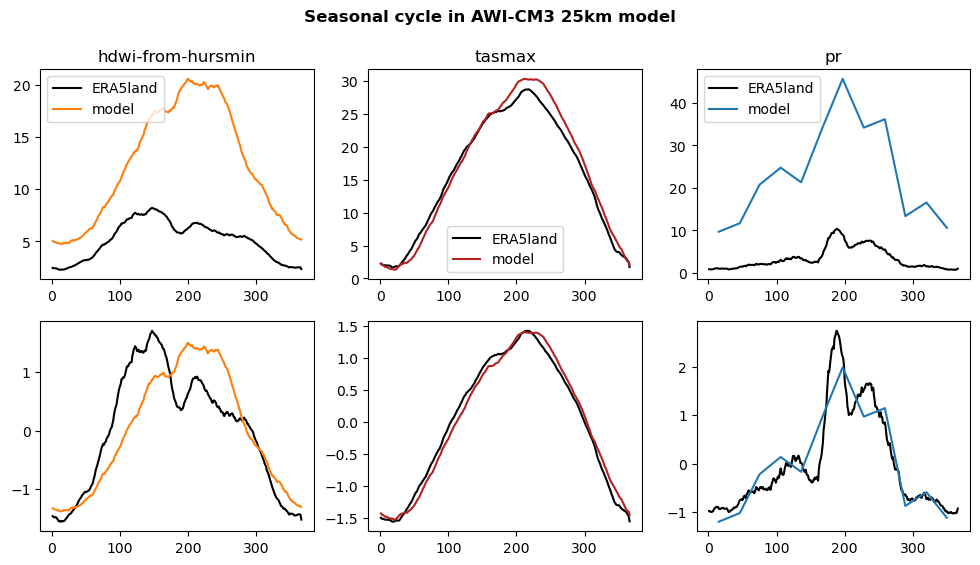

In [153]:
nc = 3; nr = 2
fig, axs = plt.subplots(ncols = nc, nrows = nr, figsize = (nc * 4, nr * 3), dpi = 100)

for i in range(nc):
    varnm = ["hdwi-from-hursmin", "tasmax", "pr"][i]
    ax = axs[0,i]
    
    # load obs
    if varnm[:2] == "pr":
        ts = xr.open_dataset("daily-ts/pr_era5_195001-202503_"+rnm+".nc")
    else:
        ts = xr.open_dataset(sorted(glob.glob("daily-ts/"+varnm+"*era5land*"+rnm+".nc"))[-1])
    ts = ts[list(ts.data_vars)[0]]
    
    col = {"hdwi-from-hursmin" : "tab:orange", "tasmax" : "firebrick", "hursmin" : "tab:green", "sfcWindmax" : "powderblue", "pr" : "tab:blue"}[varnm]
    
    k25 = xr.open_dataset("daily-ts/local-hires/"+varnm+"_AWI-CM3-25km_195001-207012_kr.nc")
    k25 = k25[list(k25.data_vars)[0]]
    
    sc_obs = seasonal_cycle(ts, sm = 15)
    if varnm[:2] == "pr":
        sc_k25 = k25.sel(time = slice("1990","2020")).groupby("time.month").mean()
        sc_k25 = sc_k25.assign_coords(month = [datetime(2020,m,15).timetuple().tm_yday for m in range(1,13)]).rename(month = "dayofyear")
    else:
        sc_k25 = seasonal_cycle(k25, sm = 15)
    
    ax.plot(sc_obs.dayofyear, sc_obs, color = "k", label = "ERA5land")
    ax.plot(sc_k25.dayofyear, sc_k25, color = col, label = "model")
    
    axs[1,i].plot(sc_obs.dayofyear, scale(sc_obs), color = "k", label = "ERA5land")
    axs[1,i].plot(sc_k25.dayofyear, scale(sc_k25), color = col, label = "model")

    ax.set_title(varnm)
    ax.legend()
    
plt.suptitle("Seasonal cycle in AWI-CM3 25km model", fontweight = "bold")
plt.savefig("fig/mdl-eval_seasonal-cycle_25km.png")

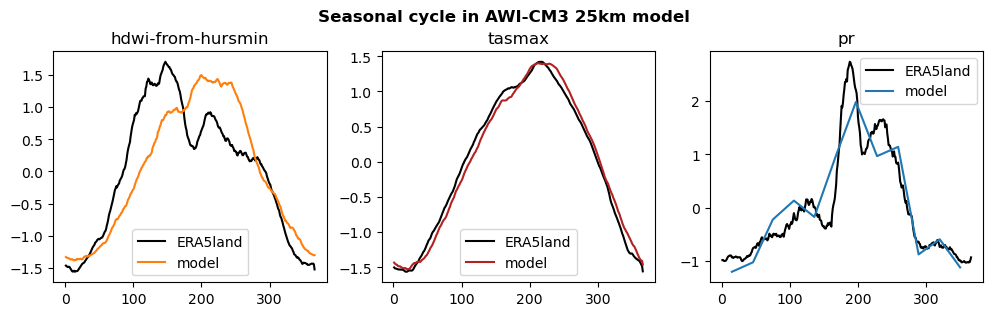

In [29]:
nc = 3; nr = 1
fig, axs = plt.subplots(ncols = nc, nrows = nr, figsize = (nc * 4, nr * 3), dpi = 100)

for i in range(nc):
    varnm = ["hdwi-from-hursmin", "tasmax", "pr"][i]
    ax = axs[i]
    
    # load obs
    if varnm[:2] == "pr":
        ts = xr.open_dataset("daily-ts/pr_era5_195001-202503_"+rnm+".nc")
    else:
        ts = xr.open_dataset(sorted(glob.glob("daily-ts/"+varnm+"*era5land*"+rnm+".nc"))[-1])
    ts = ts[list(ts.data_vars)[0]]
    
    col = {"hdwi-from-hursmin" : "tab:orange", "tasmax" : "firebrick", "hursmin" : "tab:green", "sfcWindmax" : "powderblue", "pr" : "tab:blue"}[varnm]
    
    k25 = xr.open_dataset("daily-ts/local-hires/"+varnm+"_AWI-CM3-25km_195001-207012_kr.nc")
    k25 = k25[list(k25.data_vars)[0]]
    
    sc_obs = seasonal_cycle(ts, sm = 15)
    if varnm[:2] == "pr":
        sc_k25 = k25.sel(time = slice("1990","2020")).groupby("time.month").mean()
        sc_k25 = sc_k25.assign_coords(month = [datetime(2020,m,15).timetuple().tm_yday for m in range(1,13)]).rename(month = "dayofyear")
    else:
        sc_k25 = seasonal_cycle(k25, sm = 15)
       
    ax.plot(sc_obs.dayofyear, scale(sc_obs), color = "k", label = "ERA5land")
    ax.plot(sc_k25.dayofyear, scale(sc_k25), color = col, label = "model")

    ax.set_title(varnm)
    ax.legend()
    
plt.suptitle("Seasonal cycle in AWI-CM3 25km model", fontweight = "bold", y = 1.02)
plt.savefig("fig/mdl-eval_seasonal-cycle-scaled_25km.png")


# Spatial pattern

In [88]:
framing = "cmip6"
varnm = "hdwi"

# load obs
da = xr.open_dataset(sorted(glob.glob("data/era5land/"+varnm+"*.nc"))[-1])
da = da[list(da.data_vars)[0]]
sp_era5 = da.sel(time = slice("1990","2020")).groupby("time.month")[3].mean("time")

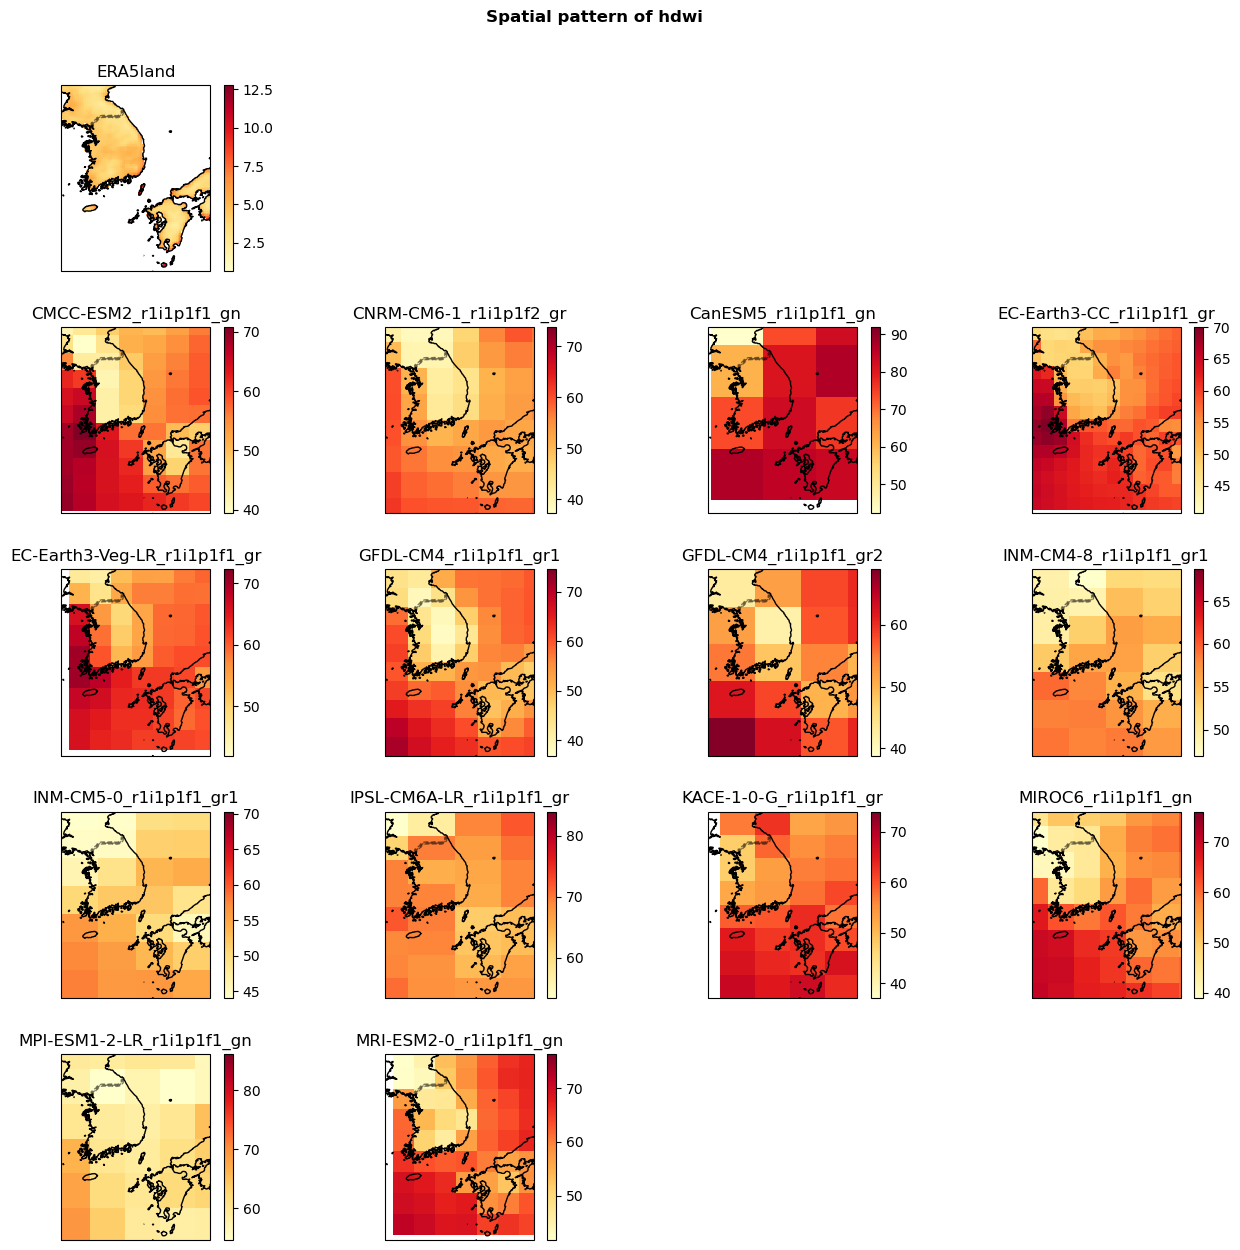

In [97]:
# list models & set up figures
fl = sorted(glob.glob("data/"+framing+"/"+varnm+"*"))
# if framing == "cmip6": fl = glob.glob("data/25km/"+varnm+"*.nc") + fl

nc = 4; nr = int(np.ceil(len(fl)/nc))+1

fig, axs = plt.subplots(ncols = nc, nrows = nr, figsize = (nc * 4, nr * 3), dpi = 100, subplot_kw = {"projection" : mapproj, "extent" : [xn,xx,yn,yx]})
plt.subplots_adjust(hspace = 0.3)

plot_kwargs = {"cbar_kwargs" : {"label" : ""},
               "cmap" : {"hdwi" : "YlOrRd"}[varnm]}

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
sp_era5.plot(ax = axs[0,0], **plot_kwargs)
axs[0,0].set_title("ERA5land")
axs[0,0].coastlines()
axs[0,0].add_feature(cartopy.feature.BORDERS, color = "k", alpha = 0.5, ls = "--")

for ax in axs[0,1:]: ax.set_axis_off()
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
for i in range(len(fl)):
    ax = axs.flatten()[nc:][i]
    
    mda = xr.open_dataset(fl[i])
    mda = mda[list(mda.data_vars)[0]].sel(time = slice("1990","2020")).groupby("time.month")[3].mean("time")
    
    mda.plot(ax = ax, **plot_kwargs)
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, color = "k", alpha = 0.5, ls = "--")

    gcm = "_".join(fl[i].split("_")[1:4])
    if "25km" in gcm: gcm = "AWI-CW3 25km"
    ax.set_title(gcm)

    
for i in range(len(fl)+nc, len(axs.flatten())): axs.flatten()[i].set_axis_off()
    
plt.suptitle("Spatial pattern of "+re.sub("-"," ",varnm), fontweight = "bold", y = 0.93)
plt.savefig("fig/mdl-eval_spatial-pattern_"+varnm+"_"+framing+".png")